In [1]:
import scanpy as sc

In [2]:
from bbtnn.tnn_v3 import *

In [3]:
%%capture
adata = sc.read("/Users/lsimon/Dropbox/Platelet/BBTNN/Merge_filter.h5")
sc.pp.recipe_zheng17(adata, n_top_genes = 3000)
sc.pp.neighbors(adata, n_neighbors = 20, n_pcs = 50)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [ ]:
sc.pl.umap(adata, color = ["batch", "Celltypes"])

In [4]:
from bbtnn.tnn_v3 import *

In [12]:
batch_name = "batch"
k = 20
k_to_m_ratio = 0.75
batch_size = 32
search_k=-1
save_on_disk = True
approx = True
verbose=1

# Calculate MNNs by pairwise comparison between batches
cell_names = adata.obs_names
if(verbose > 0):
    print("Calculating MNNs...")
mnn_dict = create_dictionary_mnn(adata, batch_name, k = k, save_on_disk = save_on_disk, approx = approx, verbose = verbose)
if(verbose > 0):
    print(str(len(mnn_dict)) + " cells defined as MNNs")

num_k = round(k_to_m_ratio * len(mnn_dict))

# Calculate KNNs for residual cells
cells_for_knn = list(set(cell_names) - set(list(mnn_dict.keys())))
if(len(cells_for_knn) > num_k):
    cells_for_knn = np.random.choice(cells_for_knn, num_k, replace = False)

if(verbose > 0):
    print("Calculating KNNs")
knn_dict = create_dictionary_knn(adata, cells_for_knn, k = k, save_on_disk = save_on_disk, approx = approx)
if(verbose > 0):
    print(str(len(cells_for_knn)) + " cells defined as KNNs")

final_dict = mnn_dict
final_dict.update(knn_dict)

cells = list(final_dict.keys())

bdata = adata[cells]

# Define list of positives
if(verbose > 0):
    print("Reorder")
triplet_list = []
for i in cells:
    names = final_dict[i]
    triplet_list.append([bdata.obs_names.get_loc(x) for x in names])

# Define unique batches to same negatives from
batch_list = bdata.obs["batch"]
batch_indices = []
for i in batch_list.unique():
    batch_indices.append(list(np.where(batch_list == i)[0]))

batch_list = [list(batch_list.unique()).index(i) for i in list(batch_list)]

Calculating MNNs...
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (0, 3)
Processing datasets (1, 2)
Processing datasets (1, 3)
Processing datasets (2, 3)
3417 cells defined as MNNs
Calculating KNNs
2563 cells defined as KNNs
Reorder


KeyError: 0

In [18]:
cell_names = adata.obs_names

dataset = adata[cells_for_knn]
pcs = dataset.obsm['X_pca']

knns = dict()

dim = pcs.shape[1]
num_elements = pcs.shape[0]
p = hnswlib.Index(space='l2', dim = dim)
p.init_index(max_elements=num_elements, ef_construction=100, M=16)
p.set_ef(10)
p.add_items(pcs)
ind, distances = p.knn_query(pcs, k=k)

In [19]:
for a, b in zip(cells_for_knn[0:3], ind):
    knns[a] = [b_i for b_i in b]

In [9]:
knn_dict_old = knn_dict 

In [14]:
np.array(cells_for_knn)[0:4]

array(['1503-0', '6664-0', '4901-0', '6824-0'], dtype='<U6')

In [ ]:
knn_dict_new = knn_dict

In [11]:
knn_dict_old = knn_dict

In [23]:
set(knn_dict_new.keys()).intersection(set(knn_dict_old.keys()))

{'102-3',
 '1020-0',
 '1056-0',
 '1073-1',
 '1081-0',
 '1090-0',
 '1095-1',
 '1101-1',
 '115-2',
 '1152-0',
 '1171-0',
 '1173-1',
 '1178-1',
 '1190-2',
 '1213-1',
 '1220-2',
 '1222-2',
 '1224-0',
 '1227-2',
 '1233-0',
 '1234-0',
 '1234-1',
 '1249-0',
 '1276-1',
 '1278-0',
 '1280-2',
 '1281-0',
 '1281-1',
 '1306-1',
 '1307-2',
 '1314-0',
 '1317-0',
 '132-2',
 '1321-1',
 '1325-0',
 '1325-1',
 '1329-1',
 '1333-1',
 '1337-0',
 '1355-0',
 '1358-2',
 '1365-1',
 '1369-0',
 '1369-2',
 '1382-2',
 '1390-0',
 '1392-0',
 '1394-1',
 '1405-2',
 '1406-2',
 '1419-1',
 '1421-0',
 '1423-1',
 '1425-0',
 '143-3',
 '144-3',
 '147-3',
 '1476-0',
 '1482-0',
 '150-3',
 '1510-0',
 '1520-2',
 '1536-2',
 '1551-2',
 '1564-0',
 '1577-0',
 '1578-2',
 '1583-2',
 '1587-1',
 '1589-0',
 '1590-0',
 '1592-2',
 '16-2',
 '160-0',
 '1602-0',
 '1611-1',
 '1630-2',
 '1631-1',
 '1636-0',
 '1637-0',
 '1639-1',
 '1654-0',
 '1671-0',
 '1680-2',
 '1693-1',
 '1694-0',
 '1694-2',
 '1700-0',
 '1701-0',
 '1714-2',
 '1719-2',
 '1720-2'

In [ ]:
%%time
model = TNN(k = 50, batch_size = 32, k_to_m_ratio = 1, n_epochs_without_progress = 5, verbose = 2)
model.fit(X = adata, batch_name = "batch", Y = None)
embedding = model.transform(X = adata)

Calculating MNNs...
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (0, 3)
Processing datasets (1, 2)
Processing datasets (1, 3)
Processing datasets (2, 3)
5633 cells defined as MNNs
Calculating KNNs
5633 cells defined as KNNs
Reorder


W0330 21:58:26.745735 17600 deprecation.py:323] From C:\Users\lsimon\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4075: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0330 21:58:26.891331 17600 deprecation.py:506] From C:\Users\lsimon\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Training neural network
Epoch 1/1000
353/353 - 4s - loss: 0.9253
Epoch 2/1000
353/353 - 2s - loss: 0.5152
Epoch 3/1000
353/353 - 2s - loss: 0.4238
Epoch 4/1000
353/353 - 2s - loss: 0.3777
Epoch 5/1000
353/353 - 2s - loss: 0.3371
Epoch 6/1000
353/353 - 2s - loss: 0.3172
Epoch 7/1000
353/353 - 2s - loss: 0.3168
Epoch 8/1000
353/353 - 2s - loss: 0.3014
Epoch 9/1000
353/353 - 2s - loss: 0.2889
Epoch 10/1000
353/353 - 2s - loss: 0.2787
Epoch 11/1000
353/353 - 2s - loss: 0.2676
Epoch 12/1000
353/353 - 2s - loss: 0.2650
Epoch 13/1000
353/353 - 2s - loss: 0.2701
Epoch 14/1000
353/353 - 2s - loss: 0.2530
Epoch 15/1000
353/353 - 2s - loss: 0.2493
Epoch 16/1000
353/353 - 2s - loss: 0.2537
Epoch 17/1000
353/353 - 2s - loss: 0.2484
Epoch 18/1000
353/353 - 2s - loss: 0.2495
Epoch 19/1000
353/353 - 2s - loss: 0.2336
Epoch 20/1000
353/353 - 2s - loss: 0.2480
Epoch 21/1000
353/353 - 2s - loss: 0.2379
Epoch 22/1000
353/353 - 2s - loss: 0.2458
Epoch 23/1000
353/353 - 2s - loss: 0.2246
Epoch 24/1000
353/3

In [7]:
adata.obsm["X_umap"] = embedding
sc.pl.umap(adata, color = ["batch", "Celltypes"], legend_loc = "on data")

NameError: name 'embedding' is not defined

### Add supervision to loss function

In [17]:
uniq = list(adata.obs["Celltypes"].unique())
y_labels = []
for i in adata.obs["Celltypes"]:
    y_labels.append(uniq.index(i))

In [20]:
%%time
model = TNN(k = 50, batch_size = 32, n_epochs_without_progress = 5, verbose = 2, supervision_weight=1)
model.fit(X = adata, batch_name = "batch", Y = y_labels)
embedding = model.transform(X = adata)

Calculating MNNs...
Processing datasets (0, 1)
Processing datasets (0, 2)
Processing datasets (0, 3)
Processing datasets (1, 2)
Processing datasets (1, 3)
Processing datasets (2, 3)
5578 cells defined as MNNs
Calculating KNNs
4184 cells defined as KNNs
Reorder
Training neural network
Epoch 1/1000
306/306 - 5s - loss: 0.9432
Epoch 2/1000
306/306 - 2s - loss: 0.5410
Epoch 3/1000
306/306 - 2s - loss: 0.4493
Epoch 4/1000
306/306 - 2s - loss: 0.3975
Epoch 5/1000
306/306 - 2s - loss: 0.3786
Epoch 6/1000
306/306 - 2s - loss: 0.3438
Epoch 7/1000
306/306 - 2s - loss: 0.3352
Epoch 8/1000
306/306 - 2s - loss: 0.3202
Epoch 9/1000
306/306 - 2s - loss: 0.3216
Epoch 10/1000
306/306 - 2s - loss: 0.3003
Epoch 11/1000
306/306 - 2s - loss: 0.3012
Epoch 12/1000
306/306 - 2s - loss: 0.2833
Epoch 13/1000
306/306 - 2s - loss: 0.2844
Epoch 14/1000
306/306 - 2s - loss: 0.2759
Epoch 15/1000
306/306 - 1s - loss: 0.2735
Epoch 16/1000
306/306 - 2s - loss: 0.2701
Epoch 17/1000
306/306 - 1s - loss: 0.2670
Epoch 18/1

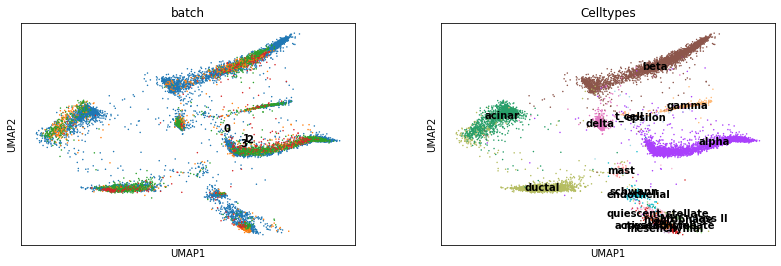

In [21]:
adata.obsm["X_umap"] = embedding
sc.pl.umap(adata, color = ["batch", "Celltypes"], legend_loc = "on data")

### Add semi-supervision to loss function

In [ ]:
mask = np.random.choice(range(len(Y_train)), size=len(Y_train) // 2, replace=False)
Y_train_masked = np.array(Y_train, dtype=np.int8) # Can't use uint to represent
Y_train_masked[mask] = -1